# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [ ]:
# import your package
%load_ext autoreload
%autoreload 2

In [ ]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")



transformers.__version__

In [ ]:
from src.helpers.lightning import read_metrics_csv

# Dataset

In [ ]:
from datasets import load_from_disk, concatenate_datasets
fs = [
    # '../.ds/HuggingFaceH4starchat_beta_imdb_train_9002',
    '../.ds/HuggingFaceH4starchat_beta_imdb_train_12002',
    # '../.ds/HuggingFaceH4starchat_beta_amazon_polarity_train_12002'
]

# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds1 = concatenate_datasets([load_from_disk(f) for f in fs])
ds1

In [ ]:
from src.datasets.load import ds2df

## Filter

In [ ]:
# lets select only the ones where
df = ds2df(ds1)
df

In [ ]:
# # just select the question where the model knows the answer. 
d = df.query('sys_instr_name=="truth"').set_index("example_i")

# # these are the ones where it got it right when asked to tell the truth
m1 = d.llm_ans==d.label_true
known_indices = d[m1].index
print(f"select rows are {m1.mean():2.2%} based on knowledge")
# # convert to row numbers, and use datasets to select
known_rows = df['example_i'].isin(known_indices)
known_rows_i = df[known_rows].index

# also restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
m = np.abs(df.ans0-df.ans1)>0.05
print(f"selected rows are {m.mean():2.2%} for significance")
significant_rows = m[m].index

allowed_rows_i = set(known_rows_i).intersection(significant_rows)
# allowed_rows_i = significant_rows
ds = ds1.select(allowed_rows_i)
ds

## Transform: Normalize by activation

In [ ]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds

## Lightning DataModule

In [ ]:
df = ds2df(ds)
df.head(4)

In [ ]:
# ds?

What are we detecting? If the right example of the pair is more deceptive.

Now it's only deceptive if
- it was asked to lie
- it knows the truth
- it gave the wrong answer (around 10% of the time)( it's hard to get these models to lie by encouragement rather than instruction)


In [ ]:
from src.helpers import switch2bool, bool2switch
from src.datasets.dm import imdbHSDataModule

In [ ]:
batch_size = 120
# test and cache
dm = imdbHSDataModule(ds, batch_size=batch_size)
dm.setup('train')

dl_val = dm.val_dataloader()
dl_train = dm.train_dataloader()
len(dl_train), len(dl_val)

In [ ]:
b = next(iter(dl_train))
x0, x1, y = b
x0.shape

# Data prep

We do two inferences on the same inputs. Since we have dropout enabled, even during inference, we get two slightly different hidden states `hs1` and `hs2`, and two slightly different probabilities for our yes and no output tokens `p1` `p2`. We also have the true answer `t`

So there are a few ways we can set up the problem. 

We can vary x:
- `model(hs1)-model(hs2)=y`
- `model(hs1-hs2)==y`

And we can try differen't y's:
- direction with a ranked loss. This could be unsupervised.
- magnitude with a regression loss
- vector (direction and magnitude) with a regression loss

# QC: Linear supervised probes


Let's verify that the model's representations are good

Before trying CCS, let's make sure there exists a direction that classifies examples as true vs false with high accuracy; if supervised logistic regression accuracy is bad, there's no hope of unsupervised CCS doing well.

Note that because logistic regression is supervised we expect it to do better but to have worse generalisation that equivilent unsupervised methods. However in this case CSS is using a deeper model so it is more complicated.


## Try a classification of direction to truth

In [ ]:
# dm.y

In [ ]:
# n = len(df)

# # Define X and y
# X = (dm.hs1-dm.hs0).reshape((n, -1))#/dm.y[:, None]
# y = dm.y>0

# # split
# n = len(y)
# max_rows = 300
# print('split size', n//2)
# X_train, X_test = X[:n//2], X[n//2:]
# y_train, y_test = y[:n//2], y[n//2:]
# X_train = X_train[:max_rows]
# y_train = y_train[:max_rows]
# X_test = X_test[:max_rows]
# y_test = y_test[:max_rows]

# # scale
# scaler = RobustScaler()
# scaler.fit(X_train)
# X_train2 = scaler.transform(X_train)
# X_test2 = scaler.transform(X_test)
# print('lr')

# lr = LogisticRegression(class_weight="balanced", penalty="l2", max_iter=100)
# lr.fit(X_train2, y_train>0)

In [ ]:
# y.mean()

In [ ]:
# print("Logistic cls acc: {:2.2%} [TRAIN]".format(lr.score(X_train2, y_train>0)))
# print("Logistic cls acc: {:2.2%} [TEST]".format(lr.score(X_test2, y_test>0)))

# m = df['instructed_to_lie'][n//2:][:max_rows]
# y_test_pred = lr.predict(X_test2)
# acc_w_lie = ((y_test_pred[m]>0)==(y_test[m]>0)).mean()
# acc_wo_lie = ((y_test_pred[~m]>0)==(y_test[~m]>0)).mean()
# print(f'test acc w lie {acc_w_lie:2.2%}')
# print(f'test acc wo lie {acc_wo_lie:2.2%}')

In [ ]:
# primary_baseline = roc_auc_score(y_test>0, y_test_pred)
# primary_baseline

# LightningModel

In [ ]:
# # from src.probes.conv import PLConvProbe
# import torch
# import torch.nn as nn
# import torch.nn.functional as F
# from src.probes.conv import PLConvProbe
# from src.probes.pl_ranking import PLRanking
# from torchmetrics.functional import accuracy
# from src.helpers import switch2bool, bool2switch

# class ConvProbe(nn.Module):
#     def __init__(self, c_in, depth=0, hs=16, dropout=0, input_dropout=0):
#         super().__init__()

#         layers = [
#             nn.BatchNorm1d(c_in, affine=False),  # this will normalise the inputs
#             nn.Dropout1d(input_dropout),
            
#             nn.Conv1d(c_in, hs*(depth+1), kernel_size=3),
#             nn.ReLU(),
#             nn.BatchNorm1d(hs*(depth+1)),
#             nn.AdaptiveAvgPool1d(5),
#             nn.Flatten(),
#             nn.Linear(hs*(depth+1)*5, hs*(depth+1)),
#         ]
#         for i in range(depth):
#             layers += [
#                 nn.Linear(hs*(depth-i+1), hs*(depth-i)),
#                 nn.ReLU(),
#                 nn.BatchNorm1d(hs*(depth-i)),
                
#             ]
#         # layers += [nn.AdaptiveAvgPool1d(1)]
#         self.net = nn.Sequential(*layers)
#         self.head = nn.Sequential(
#             nn.Linear(hs, hs), nn.ReLU(),
#             nn.Dropout(dropout), nn.Linear(hs, 1)            
#         )

#     def forward(self, x):
#         h = self.net(x)
#         # print(1, h.shape)
#         h = h.squeeze(-1)
#         # print(1, h.shape)
#         return self.head(h)

# class PLConvProbe(PLRanking):
#     def __init__(self, c_in, total_steps, lr=4e-3, weight_decay=1e-9, **kwargs):
#         super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
#         self.probe = ConvProbe(c_in, **kwargs)
#         self.save_hyperparameters()
        
        
#     def _step(self, batch, batch_idx, stage='train'):
#         x0, x1, y = batch
#         ypred0 = self(x0)
#         ypred1 = self(x1)
        
#         if stage=='pred':
#             return (ypred1-ypred0).float()
        
#         # loss = F.smooth_l1_loss(ypred1-ypred0, y)
#         loss = F.margin_ranking_loss(ypred1, ypred0, y, margin=0.5)
#         # self.log(f"{stage}/loss", loss)
        
#         y_cls = switch2bool(ypred1-ypred0)
#         self.log(f"{stage}/acc", accuracy(y_cls, y>0, "binary"), on_epoch=True, on_step=False)
#         self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
#         self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
#         return loss
    
    

In [255]:
# from src.probes.conv import PLConvProbe
import torch
import torch.nn as nn
import torch.nn.functional as F
from src.probes.conv import PLConvProbe
from src.probes.pl_ranking import PLRanking
from torchmetrics.functional import accuracy
from src.helpers import switch2bool, bool2switch

class ConvProbe(nn.Module):
    def __init__(self, c_in, depth=0, hs=16, dropout=0, input_dropout=0):
        super().__init__()
        self.n_groups = 24 # groups of neurons
        c = c_in//self.n_groups
        P = 3

        cw = hs*(depth+1)
        self.layers1 = nn.Sequential(*[
            nn.BatchNorm2d(c, affine=False),  # this will normalise the inputs
            nn.Dropout2d(input_dropout),
            
            nn.Conv2d(c, c//4, kernel_size=(1, 3)),
            nn.Conv2d(c//4, cw, kernel_size=(3, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(cw),
            
            nn.Conv2d(cw, cw, kernel_size=(1, 3)),
            nn.Conv2d(cw, cw, kernel_size=(3, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(cw),
            
            
            nn.Conv2d(cw, cw, kernel_size=(1, 3)),
            nn.Conv2d(cw, cw, kernel_size=(3, 1)),
            nn.ReLU(),
            nn.BatchNorm2d(cw),            
            
            nn.AdaptiveAvgPool2d(P),
            nn.Flatten(),
            
        ])
        layers2 = [nn.Linear(hs*(depth+1)*P*P, hs*(depth+1)),]
        for i in range(depth):
            layers2 += [
                nn.Linear(hs*(depth-i+1), hs*(depth-i)),
                nn.ReLU(),
                nn.BatchNorm1d(hs*(depth-i)),
                
            ]
        # layers += [nn.AdaptiveAvgPool1d(1)]
        self.layers2 = nn.Sequential(*layers2)
        self.head = nn.Sequential(
            nn.Linear(hs, hs), nn.ReLU(),
            nn.Dropout(dropout), nn.Linear(hs, 1)            
        )

    def forward(self, x):
        x = x.reshape((len(x), -1, self.n_groups, x.shape[-1]))
        # print(x.shape, 3)
        h = self.layers1(x)
        # print(h.shape, 4)
        h = self.layers2(h)
        # print(h.shape, 5)
        # print(1, h.shape)
        h = h.squeeze(-1)
        # print(1, h.shape)
        return self.head(h)

class PLConvProbe(PLRanking):
    def __init__(self, c_in, total_steps, lr=4e-3, weight_decay=1e-9, **kwargs):
        super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
        self.probe = ConvProbe(c_in, **kwargs)
        self.save_hyperparameters()
        
        
    def _step(self, batch, batch_idx, stage='train'):
        x0, x1, y = batch
        ypred0 = self(x0)
        ypred1 = self(x1)
        
        if stage=='pred':
            return (ypred1-ypred0).float()
        
        # loss = F.smooth_l1_loss(ypred1-ypred0, y)
        loss = F.margin_ranking_loss(ypred1, ypred0, y, margin=0.5)
        # self.log(f"{stage}/loss", loss)
        
        y_cls = switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/n", len(y), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss
    
    

# Run

In [256]:
# quiet please
torch.set_float32_matmul_precision('medium')

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*F-score.*")

## Prep dataloader/set

In [257]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
b = next(iter(dl_train))

In [258]:
c_in = b[0].shape[1]
print(b[0].shape)
net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=2, hs=4, lr=3e-3, 
          weight_decay=1, 
          dropout=0.1, 
          input_dropout=0.3,
          )

torch.Size([120, 6144, 37])


In [259]:
from torchinfo import summary

batch_size = 16
summary(net, input_size=b[0].shape)

Layer (type:depth-idx)                   Output Shape              Param #
PLConvProbe                              [120]                     --
├─ConvProbe: 1-1                         [120, 1]                  --
│    └─Sequential: 2-1                   [120, 108]                --
│    │    └─BatchNorm2d: 3-1             [120, 256, 24, 37]        --
│    │    └─Dropout2d: 3-2               [120, 256, 24, 37]        --
│    │    └─Conv2d: 3-3                  [120, 64, 24, 35]         49,216
│    │    └─Conv2d: 3-4                  [120, 12, 22, 35]         2,316
│    │    └─ReLU: 3-5                    [120, 12, 22, 35]         --
│    │    └─BatchNorm2d: 3-6             [120, 12, 22, 35]         24
│    │    └─Conv2d: 3-7                  [120, 12, 22, 33]         444
│    │    └─Conv2d: 3-8                  [120, 12, 20, 33]         444
│    │    └─ReLU: 3-9                    [120, 12, 20, 33]         --
│    │    └─BatchNorm2d: 3-10            [120, 12, 20, 33]         24
│    │

In [260]:

# init the model
max_epochs = 82

trainer = pl.Trainer(precision="bf16-mixed",
                     
                     gradient_clip_val=20,
                     max_epochs=max_epochs, log_every_n_steps=5)
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | probe | ConvProbe | 54.9 K
------------------------------------
54.9 K    Trainable params
0         Non-trainable params
54.9 K    Total params
0.220     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=82` reached.


In [261]:
# %debug

# Read hist

In [262]:
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
df_hist

,val/acc,val/loss,val/n,step,train/acc,train/loss,train/n
epoch,,,,,,,
0,0.496988,0.499959,996.0,16.0,0.497740,0.499925,1991.0
1,0.485944,0.499846,996.0,33.0,0.515821,0.499015,1991.0
2,0.494980,0.499207,996.0,50.0,0.492717,0.500070,1991.0
3,0.519076,0.499467,996.0,67.0,0.494224,0.499619,1991.0
4,0.488956,0.500423,996.0,84.0,0.512808,0.498870,1991.0
...,...,...,...,...,...,...,...
77,0.539157,0.483304,996.0,1325.0,0.837268,0.282201,1991.0
78,0.550201,0.477490,996.0,1342.0,0.847815,0.278243,1991.0
79,0.546185,0.476890,996.0,1359.0,0.835761,0.274493,1991.0


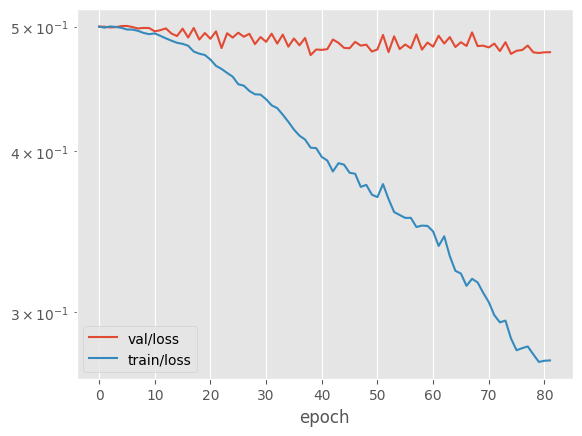

In [263]:
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)

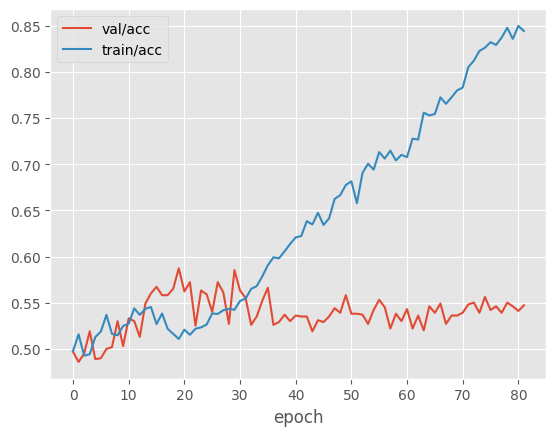

In [264]:
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()

## Predict

In [265]:
dl_test = dm.test_dataloader()
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
rs

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:480: PossibleUserWarning: Your `test_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
  rank_zero_warn(


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │    0.9201406240463257     │    0.5471887588500977     │    0.5381526350975037     │
│         test/loss         │    0.23339247703552246    │    0.47759562730789185    │    0.47705864906311035    │
│          test/n           │          1991.0           │           996.0           │           996.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

[{'test/acc/dataloader_idx_0': 0.9201406240463257,
  'test/loss/dataloader_idx_0': 0.23339247703552246,
  'test/n/dataloader_idx_0': 1991.0},
 {'test/acc/dataloader_idx_1': 0.5471887588500977,
  'test/loss/dataloader_idx_1': 0.47759562730789185,
  'test/n/dataloader_idx_1': 996.0},
 {'test/acc/dataloader_idx_2': 0.5381526350975037,
  'test/loss/dataloader_idx_2': 0.47705864906311035,
  'test/n/dataloader_idx_2': 996.0}]

In [266]:
dl_test = dm.test_dataloader()
r = trainer.predict(net, dataloaders=dl_test)
y_test_pred = np.concatenate(r)
y_test_pred.shape

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

(996,)

In [267]:
df_test = dm.df.iloc[dm.splits['test'][0]:].copy()
y_true = dl_test.dataset.tensors[2].numpy()

In [268]:
# Make a prediction dataframe with everything in it
df_test = dm.df.iloc[dm.splits['test'][0]:].copy()
df_test['probe_pred'] = y_test_pred>0
y_test_pred_bool = np.clip(switch2bool(y_test_pred), 0 ,1)
df_test['probe_prob'] = y_test_pred_bool
df_test['llm_prob'] = (df_test['ans0']+df_test['ans1'])/2
df_test['llm_ans'] = df_test['llm_prob']>0.5
df_test['conf'] = (df_test['ans0']-df_test['ans1']).abs()
df_test['y'] = df_test['y']>0

y_true = dl_test.dataset.tensors[2].numpy()
assert ((df_test['y'].values>0.5)==(y_true>0)).all(), 'check it all lines up'

df_test

,ds_index,ds_string,example_i,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,...,expanded_ans1,txt_ans0,txt_ans1,dir_true,conf,llm_prob,llm_ans,y,probe_pred,probe_prob
2987,5150,imdb,2575,negative,<|system|>You are an AI assistant that always ...,"[negative, positive]",Sentiment with choices,1,0,True,...,0.309649,\n,\n,-0.126126,0.126126,0.141546,False,False,False,0.451172
2988,5151,imdb,2575,negative review.,<|system|>Below is an instruction that describ...,"[negative, positive]",Negation template for positive and negative,1,1,False,...,0.531121,positive,positive,-0.176169,0.176169,0.597834,True,False,True,0.898438
2989,5156,imdb,2578,1,<|system|>You are about to immerse yourself in...,"[0, 1]",burns_1,0,1,True,...,0.086315,0,0,0.059154,0.059154,0.056746,False,False,False,0.177734
2990,5181,imdb,2590,negative,<|system|>Below is an instruction that describ...,"[negative, positive]",Writer Expressed Sentiment,0,0,False,...,0.351236,positive,I,-0.393402,0.393402,0.490894,False,True,False,0.388672
2991,5182,imdb,2591,negative,<|system|>You are an AI assistant that always ...,"[negative, positive]",Movie Expressed Sentiment 2,1,0,True,...,0.830855,negative,positive,0.469982,0.469982,0.587186,True,True,False,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3978,8179,imdb,4089,positive,<|system|>Below is an instruction that describ...,"[negative, positive]",Reviewer Sentiment Feeling,1,1,False,...,0.821930,positive,positive,0.102643,0.102643,0.750543,True,True,True,0.529297
3979,8180,imdb,4090,positive,<|system|>You are about to immerse yourself in...,"[negative, positive]",Writer Expressed Sentiment,0,1,True,...,0.480320,negative,negative,0.138536,0.138536,0.347521,False,False,True,0.656250
3980,8181,imdb,4090,negative,<|system|>Below is an instruction that describ...,"[negative, positive]",Movie Expressed Sentiment,0,0,False,...,0.330161,negative,negative,0.248395,0.248395,0.174902,False,False,False,0.000000
3981,8190,imdb,4095,bad,<|system|>You've been assigned a role in a cla...,"[bad, good]",Reviewer Opinion bad good choices,1,0,True,...,0.763606,good,good,-0.170246,0.170246,0.835655,True,False,True,0.549805


In [269]:
def get_acc_subset(df, query):
    df_s = df.query(query)
    acc = (df_s['probe_pred']==df_s['y']).mean()
    print(f"acc={acc:2.2%} [{query}]")
    return acc
    
print('probe results on subsets of the data')
get_acc_subset(df_test, 'instructed_to_lie==True') # it was ph told to lie
get_acc_subset(df_test, 'instructed_to_lie==False') # it was told not to lie
get_acc_subset(df_test, 'llm_ans==label_true') # the llm gave the true ans
get_acc_subset(df_test, 'llm_ans==label_instructed') # the llm gave the desired ans
get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed') # it was told to lie, and it did lie
get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed')

probe results on subsets of the data
acc=52.13% [instructed_to_lie==True]
acc=60.00% [instructed_to_lie==False]
acc=56.70% [llm_ans==label_true]
acc=57.56% [llm_ans==label_instructed]
acc=50.62% [instructed_to_lie==True & llm_ans==label_instructed]
acc=52.76% [instructed_to_lie==True & llm_ans!=label_instructed]


0.5275590551181102

# RESULTS

In [270]:
acc = (df_test['y']==(y_test_pred_bool>0.5)).mean()

# print(f"  PRIMARY BASELINE roc_auc={primary_baseline:2.2%} from linear classifier")
print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")

⭐PRIMARY METRIC⭐ acc=55.72% from probe


# Out of sample

Lets see how far it generalizes

In [271]:
def try_fine_tune(dm):
    dl_train = dm.train_dataloader()
    dl_val = dm.val_dataloader()
    dl_test = dm.test_dataloader()
    b = next(iter(dl_train))
    max_epochs = 42
    c_in = b[0].shape[1]
    print(b[0].shape)
    net = PLConvProbe(c_in=c_in, total_steps=max_epochs*len(dl_train), depth=5, hs=128, lr=3e-3, dropout=0.1, input_dropout=0.1)
    trainer = pl.Trainer(precision="bf16-mixed",
                        
                        gradient_clip_val=20,
                        max_epochs=max_epochs, log_every_n_steps=5)
    trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)
    df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
    rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])
    return df_hist, rs

In [272]:
oos_dataset_fs = [
    # '../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-a-b-simple-prompt_N807_2shots_cd0a7f',
    # '../.ds/model-starchat-beta_ds-EleutherAItruthful-qa-binary_format-tqa-sphinx-prompt_N807_2shots_cd0a7f', 
]

In [273]:
batch_size = 12
for f in oos_dataset_fs:
    print(f)
    ds2a = load_from_disk(f)

    # restrict it to significant permutations. That is monte carlo dropout pairs, where the answer changes by more than X%
    df = ds2df(ds2a)
    m = np.abs(df.ans0-df.ans1)>0.1
    significant_rows = m[m].index

    # allowed_rows_i = set(known_rows_i).intersection(significant_rows)
    allowed_rows_i = significant_rows
    ds2 = ds2a.select(allowed_rows_i)
    print(f"selected rows are {len(ds2)/len(ds2a):2.2%}")
    print(len(ds2))

    dm2 = imdbHSDataModule(ds2, batch_size=batch_size)
    dm2.setup('train')

    dl_val2 = dm2.val_dataloader()
    dl_train2 = dm2.train_dataloader()
    dl_test2 = dm2.test_dataloader()
    print(len(dl_train2), len(dl_val2), len(dl_test2))
    rs2 = trainer.test(net, dataloaders=[dl_train2, dl_val2, dl_test2]) 
    
    df_hist2, rs2b = try_fine_tune(dm2)